In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar xf /content/spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [ ]:
!curl -L http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz -o data.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2402k  100 2402k    0     0  2941k      0 --:--:-- --:--:-- --:--:-- 2937k


In [ ]:
# %fs ls "file:/databricks/driver"

In [ ]:
df = spark.read.json('data.json.gz')
df.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|1384719342|  [0, 0]|    5.0|Not much to write...|02 28, 2014|A2IBPI20UZIR0U|cassandra tu "Yea...|                good|    1393545600|
|1384719342|[13, 14]|    5.0|The product does ...|03 16, 2013|A14VAT5EAX3D9S|                Jake|                Jake|    1363392000|
|1384719342|  [1, 1]|    5.0|The primary job o...|08 28, 2013|A195EZSQDW3E21|Rick Bennette "Ri...|It Does The Job Well|    1377648000|
|1384719342|  [0, 0]|    5.0|Nice windscreen p...|02 14, 2014|A2C00NNG1ZQQG2|RustyBill "Sunday...|GOOD WINDSCREEN F...|    1392336000|
|1384719342|  [0, 0]|    5.0|This pop filter i...|02 21

In [ ]:
# only select the necessary rows
df = df.select('asin','overall','reviewText','reviewerID')
# Convert unique strings to integer using StringIndexer
asin_indexer = StringIndexer(inputCol="asin", outputCol="itemId")
reviewerID_indexer = StringIndexer(inputCol="reviewerID", outputCol="userId")

df = asin_indexer.fit(df).transform(df)
df = reviewerID_indexer.fit(df).transform(df)

In [ ]:
df = df.select('userId','itemId','reviewText','overall')
df = df.withColumnRenamed('overall', 'rating')

df.show()

+------+------+--------------------+------+
|userId|itemId|          reviewText|rating|
+------+------+--------------------+------+
|  66.0| 703.0|Not much to write...|   5.0|
| 266.0| 703.0|The product does ...|   5.0|
| 395.0| 703.0|The primary job o...|   5.0|
|1048.0| 703.0|Nice windscreen p...|   5.0|
|1311.0| 703.0|This pop filter i...|   5.0|
|  51.0| 562.0|So good that I bo...|   5.0|
| 290.0| 562.0|I have used monst...|   5.0|
| 374.0| 562.0|I now use this ca...|   3.0|
|  13.0| 562.0|Perfect for my Ep...|   5.0|
| 183.0| 562.0|Monster makes the...|   5.0|
|   4.0| 562.0|Monster makes a w...|   5.0|
| 488.0| 704.0|I got it to have ...|   4.0|
| 699.0| 704.0|If you are not us...|   3.0|
|  49.0| 704.0|I love it, I used...|   5.0|
| 594.0| 704.0|I bought this to ...|   5.0|
| 317.0| 704.0|I bought this to ...|   2.0|
| 104.0| 455.0|This Fender cable...|   4.0|
| 250.0| 455.0|wanted it just on...|   5.0|
|   3.0| 455.0|I've been using t...|   5.0|
|  29.0| 455.0|Fender cords look

In [ ]:
df = df.withColumn('userId', col('userId').cast('integer')).\
        withColumn('itemId', col('itemId').cast('integer')).\
        withColumn('rating', col('rating').cast('float')).\
        drop('reviewText')

df.show()

+------+------+------+
|userId|itemId|rating|
+------+------+------+
|    66|   703|   5.0|
|   266|   703|   5.0|
|   395|   703|   5.0|
|  1048|   703|   5.0|
|  1311|   703|   5.0|
|    51|   562|   5.0|
|   290|   562|   5.0|
|   374|   562|   3.0|
|    13|   562|   5.0|
|   183|   562|   5.0|
|     4|   562|   5.0|
|   488|   704|   4.0|
|   699|   704|   3.0|
|    49|   704|   5.0|
|   594|   704|   5.0|
|   317|   704|   2.0|
|   104|   455|   4.0|
|   250|   455|   5.0|
|     3|   455|   5.0|
|    29|   455|   5.0|
+------+------+------+
only showing top 20 rows



In [ ]:
paramRank = [5, 10, 25, 50]
paramReg = [0.1, 0.01, 0.001]

maxIter = 20
iter_list = [i for i in range(1,maxIter+1)]

RMSE for rank: 5 reg: 0.1 i: 1
RMSE = 7.170770505186275
RMSE for rank: 5 reg: 0.1 i: 2
RMSE = 5.966347094595826
RMSE for rank: 5 reg: 0.1 i: 3
RMSE = 5.345704312041951
RMSE for rank: 5 reg: 0.1 i: 4
RMSE = 4.818722645055194
RMSE for rank: 5 reg: 0.1 i: 5
RMSE = 4.3582068219585155
RMSE for rank: 5 reg: 0.1 i: 6
RMSE = 3.9507438911767125
RMSE for rank: 5 reg: 0.1 i: 7
RMSE = 3.568718895320345
RMSE for rank: 5 reg: 0.1 i: 8
RMSE = 3.2230091228536097
RMSE for rank: 5 reg: 0.1 i: 9
RMSE = 2.9034807120045856
RMSE for rank: 5 reg: 0.1 i: 10
RMSE = 2.609890094437168
RMSE for rank: 5 reg: 0.1 i: 11
RMSE = 2.3313265504276046
RMSE for rank: 5 reg: 0.1 i: 12
RMSE = 2.0675278439204305
RMSE for rank: 5 reg: 0.1 i: 13
RMSE = 1.835265620483831
RMSE for rank: 5 reg: 0.1 i: 14
RMSE = 1.6518297510515625
RMSE for rank: 5 reg: 0.1 i: 15
RMSE = 1.5087035476299002
RMSE for rank: 5 reg: 0.1 i: 16
RMSE = 1.4078942009164583
RMSE for rank: 5 reg: 0.1 i: 17
RMSE = 1.3441767653784646
RMSE for rank: 5 reg: 0.1 i: 1

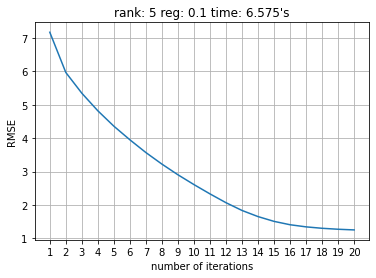

RMSE for rank: 5 reg: 0.01 i: 1
RMSE = 15.533283964960884
RMSE for rank: 5 reg: 0.01 i: 2
RMSE = 11.983326621781156
RMSE for rank: 5 reg: 0.01 i: 3
RMSE = 10.159248330115881
RMSE for rank: 5 reg: 0.01 i: 4
RMSE = 9.237325838484754
RMSE for rank: 5 reg: 0.01 i: 5
RMSE = 8.627266957154678
RMSE for rank: 5 reg: 0.01 i: 6
RMSE = 8.245482110634091
RMSE for rank: 5 reg: 0.01 i: 7
RMSE = 7.9232380882299385
RMSE for rank: 5 reg: 0.01 i: 8
RMSE = 7.642402818707029
RMSE for rank: 5 reg: 0.01 i: 9
RMSE = 7.365213971475901
RMSE for rank: 5 reg: 0.01 i: 10
RMSE = 7.14779812438444
RMSE for rank: 5 reg: 0.01 i: 11
RMSE = 6.966180917236056
RMSE for rank: 5 reg: 0.01 i: 12
RMSE = 6.80008723664725
RMSE for rank: 5 reg: 0.01 i: 13
RMSE = 6.646658462054991
RMSE for rank: 5 reg: 0.01 i: 14
RMSE = 6.496245160343658
RMSE for rank: 5 reg: 0.01 i: 15
RMSE = 6.366313491068857
RMSE for rank: 5 reg: 0.01 i: 16
RMSE = 6.248368344073176
RMSE for rank: 5 reg: 0.01 i: 17
RMSE = 6.1399452013148546
RMSE for rank: 5 reg

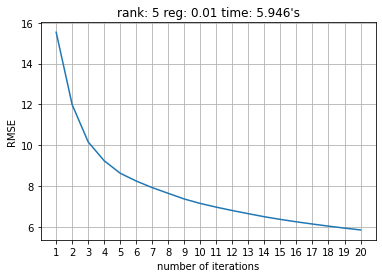

RMSE for rank: 5 reg: 0.001 i: 1
RMSE = 33.23830487074102
RMSE for rank: 5 reg: 0.001 i: 2
RMSE = 25.268045866346718
RMSE for rank: 5 reg: 0.001 i: 3
RMSE = 21.7851872924302
RMSE for rank: 5 reg: 0.001 i: 4
RMSE = 20.235423226248574
RMSE for rank: 5 reg: 0.001 i: 5
RMSE = 19.2164051054493
RMSE for rank: 5 reg: 0.001 i: 6
RMSE = 18.17505468356359
RMSE for rank: 5 reg: 0.001 i: 7
RMSE = 17.211862779393886
RMSE for rank: 5 reg: 0.001 i: 8
RMSE = 16.42099488236165
RMSE for rank: 5 reg: 0.001 i: 9
RMSE = 15.800664540688814
RMSE for rank: 5 reg: 0.001 i: 10
RMSE = 15.411864535401854
RMSE for rank: 5 reg: 0.001 i: 11
RMSE = 15.160906272910788
RMSE for rank: 5 reg: 0.001 i: 12
RMSE = 14.972996107934476
RMSE for rank: 5 reg: 0.001 i: 13
RMSE = 14.76955288169363
RMSE for rank: 5 reg: 0.001 i: 14
RMSE = 14.592735953708129
RMSE for rank: 5 reg: 0.001 i: 15
RMSE = 14.334607407657396
RMSE for rank: 5 reg: 0.001 i: 16
RMSE = 14.123261642104389
RMSE for rank: 5 reg: 0.001 i: 17
RMSE = 14.0561244340114

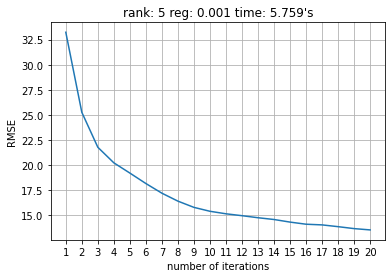

RMSE for rank: 10 reg: 0.1 i: 1
RMSE = 5.831299785123291
RMSE for rank: 10 reg: 0.1 i: 2
RMSE = 4.743411865088659
RMSE for rank: 10 reg: 0.1 i: 3
RMSE = 4.023158545153704
RMSE for rank: 10 reg: 0.1 i: 4
RMSE = 3.2993414494966875
RMSE for rank: 10 reg: 0.1 i: 5
RMSE = 2.6115420980351436
RMSE for rank: 10 reg: 0.1 i: 6
RMSE = 2.072630286218977
RMSE for rank: 10 reg: 0.1 i: 7
RMSE = 1.711426663319024
RMSE for rank: 10 reg: 0.1 i: 8
RMSE = 1.4880134736123056
RMSE for rank: 10 reg: 0.1 i: 9
RMSE = 1.3538600399033196
RMSE for rank: 10 reg: 0.1 i: 10
RMSE = 1.273726199340854
RMSE for rank: 10 reg: 0.1 i: 11
RMSE = 1.2251409943491232
RMSE for rank: 10 reg: 0.1 i: 12
RMSE = 1.1947846562288087
RMSE for rank: 10 reg: 0.1 i: 13
RMSE = 1.1753130580677196
RMSE for rank: 10 reg: 0.1 i: 14
RMSE = 1.1626009208423176
RMSE for rank: 10 reg: 0.1 i: 15
RMSE = 1.154209000730123
RMSE for rank: 10 reg: 0.1 i: 16
RMSE = 1.1486338083564174
RMSE for rank: 10 reg: 0.1 i: 17
RMSE = 1.1449149042230464
RMSE for rank

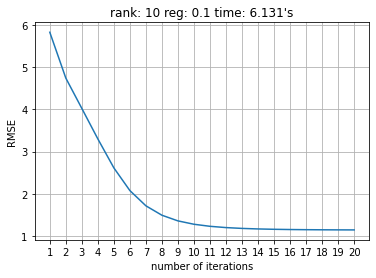

RMSE for rank: 10 reg: 0.01 i: 1
RMSE = 7.273768592102593
RMSE for rank: 10 reg: 0.01 i: 2
RMSE = 5.984594674717823
RMSE for rank: 10 reg: 0.01 i: 3
RMSE = 5.3812300459607005
RMSE for rank: 10 reg: 0.01 i: 4
RMSE = 4.967331003767468
RMSE for rank: 10 reg: 0.01 i: 5
RMSE = 4.638830287145694
RMSE for rank: 10 reg: 0.01 i: 6
RMSE = 4.363677296291129
RMSE for rank: 10 reg: 0.01 i: 7
RMSE = 4.123405047293549
RMSE for rank: 10 reg: 0.01 i: 8
RMSE = 3.904568614356126
RMSE for rank: 10 reg: 0.01 i: 9
RMSE = 3.708167864265227
RMSE for rank: 10 reg: 0.01 i: 10
RMSE = 3.540977212967075
RMSE for rank: 10 reg: 0.01 i: 11
RMSE = 3.3921845900556225
RMSE for rank: 10 reg: 0.01 i: 12
RMSE = 3.2562061199050705
RMSE for rank: 10 reg: 0.01 i: 13
RMSE = 3.1330758415418622
RMSE for rank: 10 reg: 0.01 i: 14
RMSE = 3.0185401702644628
RMSE for rank: 10 reg: 0.01 i: 15
RMSE = 2.9117727779768123
RMSE for rank: 10 reg: 0.01 i: 16
RMSE = 2.8099489242713926
RMSE for rank: 10 reg: 0.01 i: 17
RMSE = 2.715910347256479

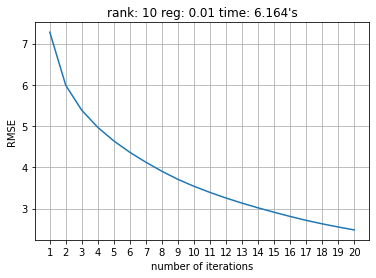

RMSE for rank: 10 reg: 0.001 i: 1
RMSE = 10.554693756313895
RMSE for rank: 10 reg: 0.001 i: 2
RMSE = 7.933017960331612
RMSE for rank: 10 reg: 0.001 i: 3
RMSE = 7.3613518067286
RMSE for rank: 10 reg: 0.001 i: 4
RMSE = 6.929145451634637
RMSE for rank: 10 reg: 0.001 i: 5
RMSE = 6.645134780424483
RMSE for rank: 10 reg: 0.001 i: 6
RMSE = 6.3761023859377515
RMSE for rank: 10 reg: 0.001 i: 7
RMSE = 6.154446779143393
RMSE for rank: 10 reg: 0.001 i: 8
RMSE = 5.95230519245681
RMSE for rank: 10 reg: 0.001 i: 9
RMSE = 5.78193699070662
RMSE for rank: 10 reg: 0.001 i: 10
RMSE = 5.63139409662403
RMSE for rank: 10 reg: 0.001 i: 11
RMSE = 5.4896367745091865
RMSE for rank: 10 reg: 0.001 i: 12
RMSE = 5.370173438845127
RMSE for rank: 10 reg: 0.001 i: 13
RMSE = 5.262819251313447
RMSE for rank: 10 reg: 0.001 i: 14
RMSE = 5.165349340918612
RMSE for rank: 10 reg: 0.001 i: 15
RMSE = 5.076053025718078
RMSE for rank: 10 reg: 0.001 i: 16
RMSE = 4.992326922045069
RMSE for rank: 10 reg: 0.001 i: 17
RMSE = 4.9197931

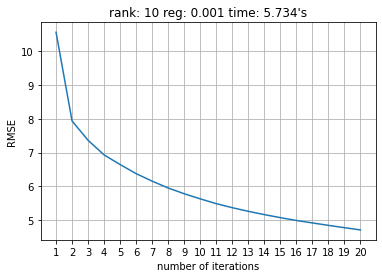

RMSE for rank: 25 reg: 0.1 i: 1
RMSE = 4.8196139868369325
RMSE for rank: 25 reg: 0.1 i: 2
RMSE = 3.67627689241029
RMSE for rank: 25 reg: 0.1 i: 3
RMSE = 2.6108702804004347
RMSE for rank: 25 reg: 0.1 i: 4
RMSE = 1.9241440180511717
RMSE for rank: 25 reg: 0.1 i: 5
RMSE = 1.5672288260357952
RMSE for rank: 25 reg: 0.1 i: 6
RMSE = 1.3804317455916488
RMSE for rank: 25 reg: 0.1 i: 7
RMSE = 1.276453268679054
RMSE for rank: 25 reg: 0.1 i: 8
RMSE = 1.2151585365011013
RMSE for rank: 25 reg: 0.1 i: 9
RMSE = 1.1773731938506198
RMSE for rank: 25 reg: 0.1 i: 10
RMSE = 1.1532507748639507
RMSE for rank: 25 reg: 0.1 i: 11
RMSE = 1.1374280348405548
RMSE for rank: 25 reg: 0.1 i: 12
RMSE = 1.126842776890614
RMSE for rank: 25 reg: 0.1 i: 13
RMSE = 1.119671697270134
RMSE for rank: 25 reg: 0.1 i: 14
RMSE = 1.1147854341544703
RMSE for rank: 25 reg: 0.1 i: 15
RMSE = 1.1114574151496386
RMSE for rank: 25 reg: 0.1 i: 16
RMSE = 1.1092044870657642
RMSE for rank: 25 reg: 0.1 i: 17
RMSE = 1.107697591272187
RMSE for ran

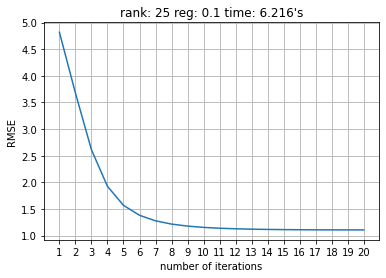

RMSE for rank: 25 reg: 0.01 i: 1
RMSE = 4.99856045929047
RMSE for rank: 25 reg: 0.01 i: 2
RMSE = 4.161677953442251
RMSE for rank: 25 reg: 0.01 i: 3
RMSE = 3.356577217410102
RMSE for rank: 25 reg: 0.01 i: 4
RMSE = 2.7238513986603765
RMSE for rank: 25 reg: 0.01 i: 5
RMSE = 2.3446178419499417
RMSE for rank: 25 reg: 0.01 i: 6
RMSE = 2.120195941345865
RMSE for rank: 25 reg: 0.01 i: 7
RMSE = 1.9759275354171844
RMSE for rank: 25 reg: 0.01 i: 8
RMSE = 1.8746229378580759
RMSE for rank: 25 reg: 0.01 i: 9
RMSE = 1.799091341992618
RMSE for rank: 25 reg: 0.01 i: 10
RMSE = 1.7407949283338082
RMSE for rank: 25 reg: 0.01 i: 11
RMSE = 1.694504531069721
RMSE for rank: 25 reg: 0.01 i: 12
RMSE = 1.6565029875081436
RMSE for rank: 25 reg: 0.01 i: 13
RMSE = 1.624389111494816
RMSE for rank: 25 reg: 0.01 i: 14
RMSE = 1.5966077778685253
RMSE for rank: 25 reg: 0.01 i: 15
RMSE = 1.5719938030512846
RMSE for rank: 25 reg: 0.01 i: 16
RMSE = 1.5497458983973809
RMSE for rank: 25 reg: 0.01 i: 17
RMSE = 1.52940635236877

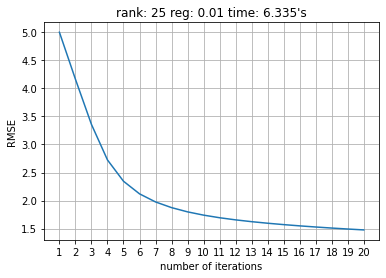

RMSE for rank: 25 reg: 0.001 i: 1
RMSE = 5.30026890245639
RMSE for rank: 25 reg: 0.001 i: 2
RMSE = 4.639257259022501
RMSE for rank: 25 reg: 0.001 i: 3
RMSE = 4.137012618406816
RMSE for rank: 25 reg: 0.001 i: 4
RMSE = 3.724811863117738
RMSE for rank: 25 reg: 0.001 i: 5
RMSE = 3.431885960675715
RMSE for rank: 25 reg: 0.001 i: 6
RMSE = 3.2292142117037668
RMSE for rank: 25 reg: 0.001 i: 7
RMSE = 3.0832012657303096
RMSE for rank: 25 reg: 0.001 i: 8
RMSE = 2.9718079900486143
RMSE for rank: 25 reg: 0.001 i: 9
RMSE = 2.881723565685109
RMSE for rank: 25 reg: 0.001 i: 10
RMSE = 2.8050095462197264
RMSE for rank: 25 reg: 0.001 i: 11
RMSE = 2.7379391093239698
RMSE for rank: 25 reg: 0.001 i: 12
RMSE = 2.6785400019666836
RMSE for rank: 25 reg: 0.001 i: 13
RMSE = 2.6254228408637372
RMSE for rank: 25 reg: 0.001 i: 14
RMSE = 2.5775622217894756
RMSE for rank: 25 reg: 0.001 i: 15
RMSE = 2.534005042568961
RMSE for rank: 25 reg: 0.001 i: 16
RMSE = 2.494142601602091
RMSE for rank: 25 reg: 0.001 i: 17
RMSE = 

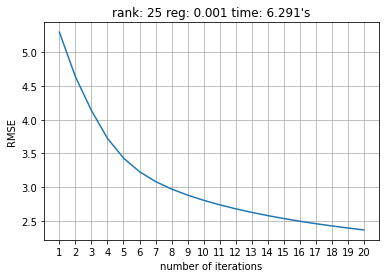

RMSE for rank: 50 reg: 0.1 i: 1
RMSE = 4.425940318722596
RMSE for rank: 50 reg: 0.1 i: 2
RMSE = 3.1464836502224514
RMSE for rank: 50 reg: 0.1 i: 3
RMSE = 2.1113894551109094
RMSE for rank: 50 reg: 0.1 i: 4
RMSE = 1.5960928198878057
RMSE for rank: 50 reg: 0.1 i: 5
RMSE = 1.3690773532544553
RMSE for rank: 50 reg: 0.1 i: 6
RMSE = 1.258564187708855
RMSE for rank: 50 reg: 0.1 i: 7
RMSE = 1.1983618030424819
RMSE for rank: 50 reg: 0.1 i: 8
RMSE = 1.162946826427837
RMSE for rank: 50 reg: 0.1 i: 9
RMSE = 1.1410468574957642
RMSE for rank: 50 reg: 0.1 i: 10
RMSE = 1.1270427678752044
RMSE for rank: 50 reg: 0.1 i: 11
RMSE = 1.117887512425985
RMSE for rank: 50 reg: 0.1 i: 12
RMSE = 1.1118226111918152
RMSE for rank: 50 reg: 0.1 i: 13
RMSE = 1.1077819657461798
RMSE for rank: 50 reg: 0.1 i: 14
RMSE = 1.1050940449775641
RMSE for rank: 50 reg: 0.1 i: 15
RMSE = 1.1033234544663697
RMSE for rank: 50 reg: 0.1 i: 16
RMSE = 1.1021819844203415
RMSE for rank: 50 reg: 0.1 i: 17
RMSE = 1.1014754405108067
RMSE for r

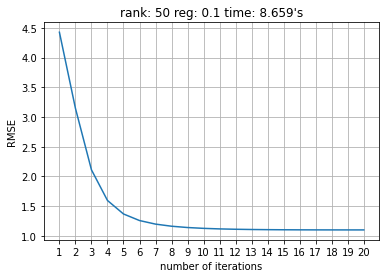

RMSE for rank: 50 reg: 0.01 i: 1
RMSE = 4.525935772661473
RMSE for rank: 50 reg: 0.01 i: 2
RMSE = 3.540339933817377
RMSE for rank: 50 reg: 0.01 i: 3
RMSE = 2.666927359471759
RMSE for rank: 50 reg: 0.01 i: 4
RMSE = 2.2089610445478423
RMSE for rank: 50 reg: 0.01 i: 5
RMSE = 1.9907747973741883
RMSE for rank: 50 reg: 0.01 i: 6
RMSE = 1.8692951361139682
RMSE for rank: 50 reg: 0.01 i: 7
RMSE = 1.7905397778029726
RMSE for rank: 50 reg: 0.01 i: 8
RMSE = 1.7338011383260428
RMSE for rank: 50 reg: 0.01 i: 9
RMSE = 1.6898313115162003
RMSE for rank: 50 reg: 0.01 i: 10
RMSE = 1.6539869401587615
RMSE for rank: 50 reg: 0.01 i: 11
RMSE = 1.6237891149855312
RMSE for rank: 50 reg: 0.01 i: 12
RMSE = 1.5978181803732725
RMSE for rank: 50 reg: 0.01 i: 13
RMSE = 1.5751483204814263
RMSE for rank: 50 reg: 0.01 i: 14
RMSE = 1.5550928848624772
RMSE for rank: 50 reg: 0.01 i: 15
RMSE = 1.5371199894076928
RMSE for rank: 50 reg: 0.01 i: 16
RMSE = 1.5208209597668656
RMSE for rank: 50 reg: 0.01 i: 17
RMSE = 1.505886478

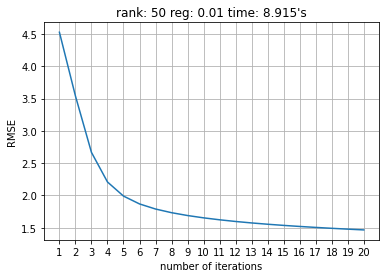

RMSE for rank: 50 reg: 0.001 i: 1
RMSE = 4.781383695182274
RMSE for rank: 50 reg: 0.001 i: 2
RMSE = 3.9686212675197945
RMSE for rank: 50 reg: 0.001 i: 3
RMSE = 3.3354126314146066
RMSE for rank: 50 reg: 0.001 i: 4
RMSE = 2.982293083812771
RMSE for rank: 50 reg: 0.001 i: 5
RMSE = 2.7942611872406817
RMSE for rank: 50 reg: 0.001 i: 6
RMSE = 2.6783928843171485
RMSE for rank: 50 reg: 0.001 i: 7
RMSE = 2.5963996604618775
RMSE for rank: 50 reg: 0.001 i: 8
RMSE = 2.5329313042745225
RMSE for rank: 50 reg: 0.001 i: 9
RMSE = 2.4809846271687315
RMSE for rank: 50 reg: 0.001 i: 10
RMSE = 2.4368841653549267
RMSE for rank: 50 reg: 0.001 i: 11
RMSE = 2.398512725204147
RMSE for rank: 50 reg: 0.001 i: 12
RMSE = 2.3645540960891314
RMSE for rank: 50 reg: 0.001 i: 13
RMSE = 2.3341306175323155
RMSE for rank: 50 reg: 0.001 i: 14
RMSE = 2.3066206626119428
RMSE for rank: 50 reg: 0.001 i: 15
RMSE = 2.2815622478506787
RMSE for rank: 50 reg: 0.001 i: 16
RMSE = 2.258595277182263
RMSE for rank: 50 reg: 0.001 i: 17
RM

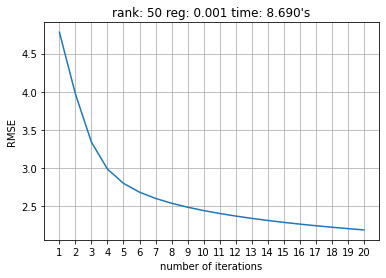

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time

(train, test) = df.randomSplit([0.8, 0.2], seed = 1234)


for rank in paramRank:
  for reg in paramReg:
    
    errors = []
    
    for i in iter_list:
      print(f"RMSE for rank: {rank} reg: {reg} i: {i}")

      als = ALS(maxIter=i, regParam=reg, rank=rank,userCol="userId", itemCol="itemId", ratingCol="rating",coldStartStrategy="drop")
      model = als.fit(train)

      # Evaluate the model by computing the RMSE on the test data
      predictions = model.transform(test)
      evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
      rmse = evaluator.evaluate(predictions)
      errors.append(rmse)
      print(f"RMSE = {rmse}")

    
    # plt.figure(figsize=(7, 7))
    
    # measuring time of training
    start_time = time.time()
    als = ALS(maxIter=maxIter, regParam=reg, rank=rank,userCol="userId", itemCol="itemId", ratingCol="rating",coldStartStrategy="drop")
    model = als.fit(train) 
    total_time = time.time() - start_time
    
    plt.plot(iter_list, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.xticks(iter_list)
    plt.title(f'rank: {rank} reg: {reg} time: {total_time:.3f}\'s')
    plt.grid(True)
    plt.show()

      